In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import pickle

In [2]:
# 2. Load the dataset
file_path = 'TCS_stock_history.csv'  # Make sure this CSV is in your working directory
df = pd.read_csv(file_path)

# Preview the data
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [3]:
# 3. Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')


In [4]:
# 4. Basic Info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB


In [5]:
df.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4463,4463.000000,4463.000000,4463.000000,4463.000000,4.463000e+03,4463.000000,4463.000000
mean,2012-08-23 19:22:31.109119488,866.936239,876.675013,856.653850,866.537398,3.537876e+06,0.071533,0.001344
min,2002-08-12 00:00:00,24.146938,27.102587,24.146938,26.377609,0.000000e+00,0.000000,0.000000
25%,2008-02-14 12:00:00,188.951782,191.571816,185.979417,188.594620,1.860959e+06,0.000000,0.000000
50%,2012-09-04 00:00:00,530.907530,534.751639,525.616849,529.713257,2.757742e+06,0.000000,0.000000
75%,2017-03-22 12:00:00,1156.462421,1165.815854,1143.622800,1154.784851,4.278625e+06,0.000000,0.000000
max,2021-09-30 00:00:00,3930.000000,3981.750000,3892.100098,3954.550049,8.806715e+07,40.000000,2.000000
std,NaN,829.905368,838.267104,821.233477,829.611313,3.273531e+06,0.965401,0.051842


In [7]:
# 2. Ensure all numeric columns are correctly typed
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


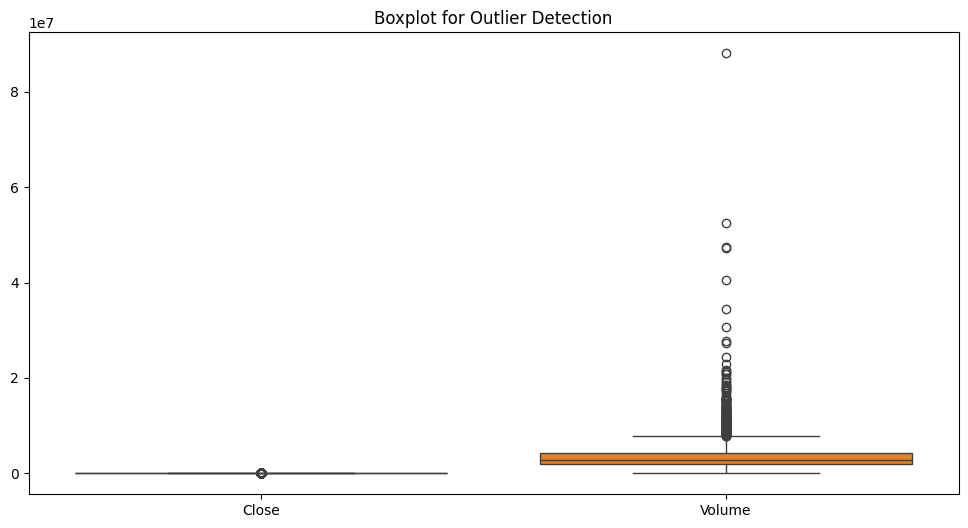

In [8]:
# 5. Check for outliers (basic boxplot approach)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Close', 'Volume']])
plt.title("Boxplot for Outlier Detection")
plt.show()


In [9]:
# 6. Summary statistics for numeric insights
df[numeric_cols].describe()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4463.000000,4463.000000,4463.000000,4463.000000,4.463000e+03,4463.000000,4463.000000
mean,866.936239,876.675013,856.653850,866.537398,3.537876e+06,0.071533,0.001344
std,829.905368,838.267104,821.233477,829.611313,3.273531e+06,0.965401,0.051842
min,24.146938,27.102587,24.146938,26.377609,0.000000e+00,0.000000,0.000000
25%,188.951782,191.571816,185.979417,188.594620,1.860959e+06,0.000000,0.000000
50%,530.907530,534.751639,525.616849,529.713257,2.757742e+06,0.000000,0.000000
75%,1156.462421,1165.815854,1143.622800,1154.784851,4.278625e+06,0.000000,0.000000
max,3930.000000,3981.750000,3892.100098,3954.550049,8.806715e+07,40.000000,2.000000


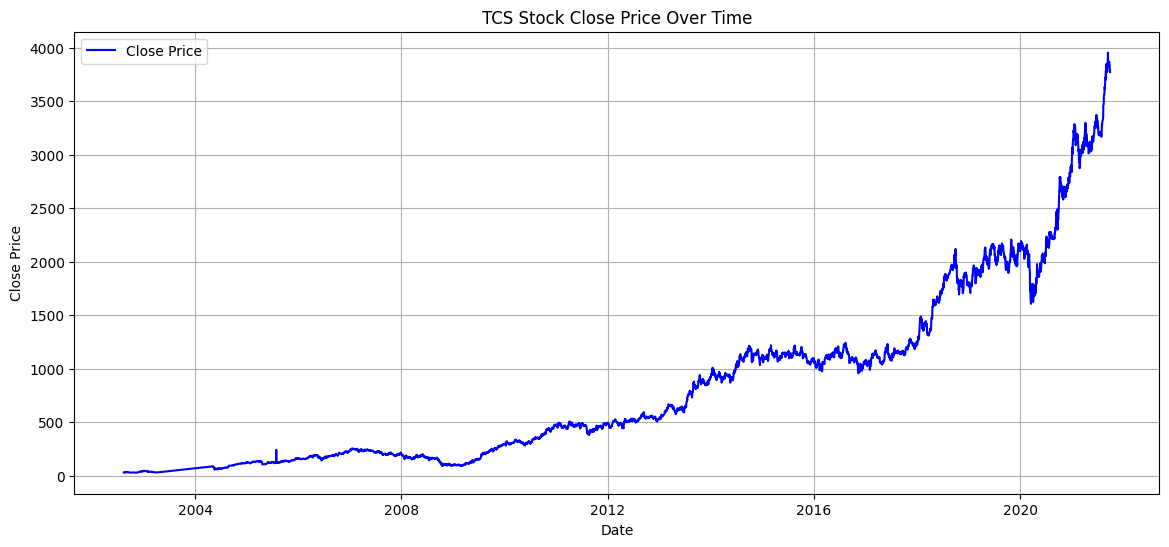

In [10]:
#close price over time
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], color='blue', label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('TCS Stock Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


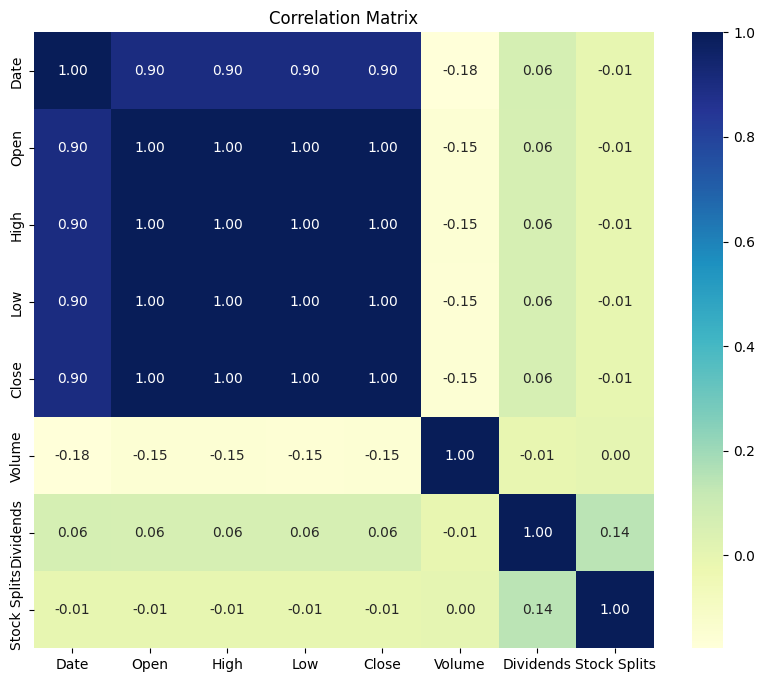

In [11]:
#correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


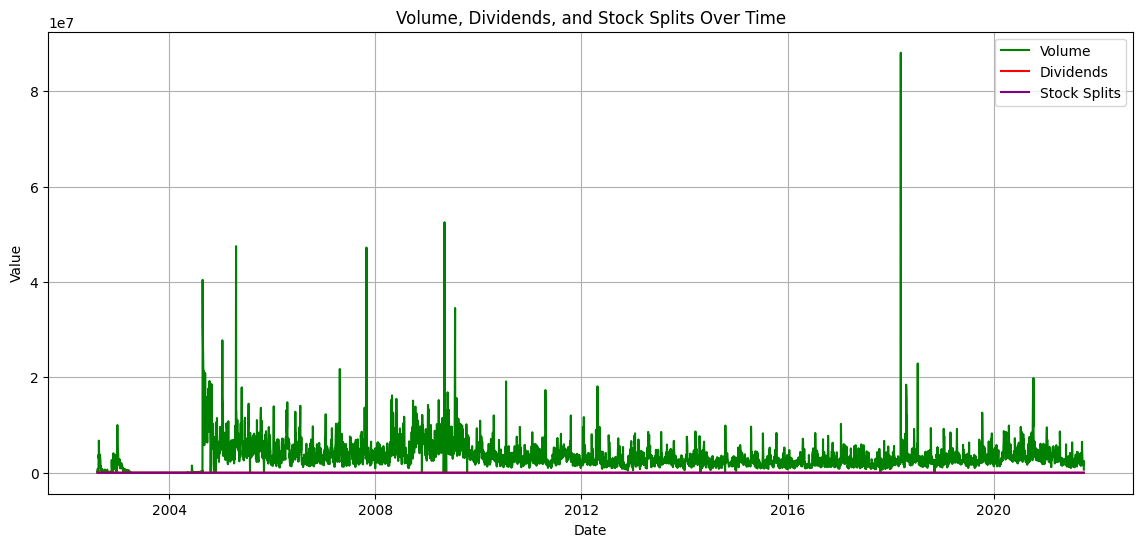

In [12]:
#Volume, Dividends & Stock Splits Over Time
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Volume'], label='Volume', color='green')
plt.plot(df['Date'], df['Dividends'], label='Dividends', color='red')
plt.plot(df['Date'], df['Stock Splits'], label='Stock Splits', color='purple')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Volume, Dividends, and Stock Splits Over Time')
plt.legend()
plt.grid(True)
plt.show()


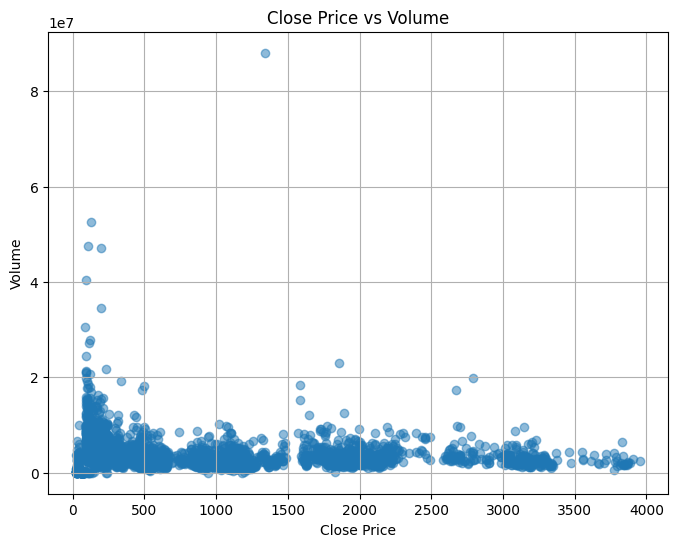

In [13]:
#Scatter: Close Price vs Volume
plt.figure(figsize=(8, 6))
plt.scatter(df['Close'], df['Volume'], alpha=0.5)
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.title('Close Price vs Volume')
plt.grid(True)
plt.show()


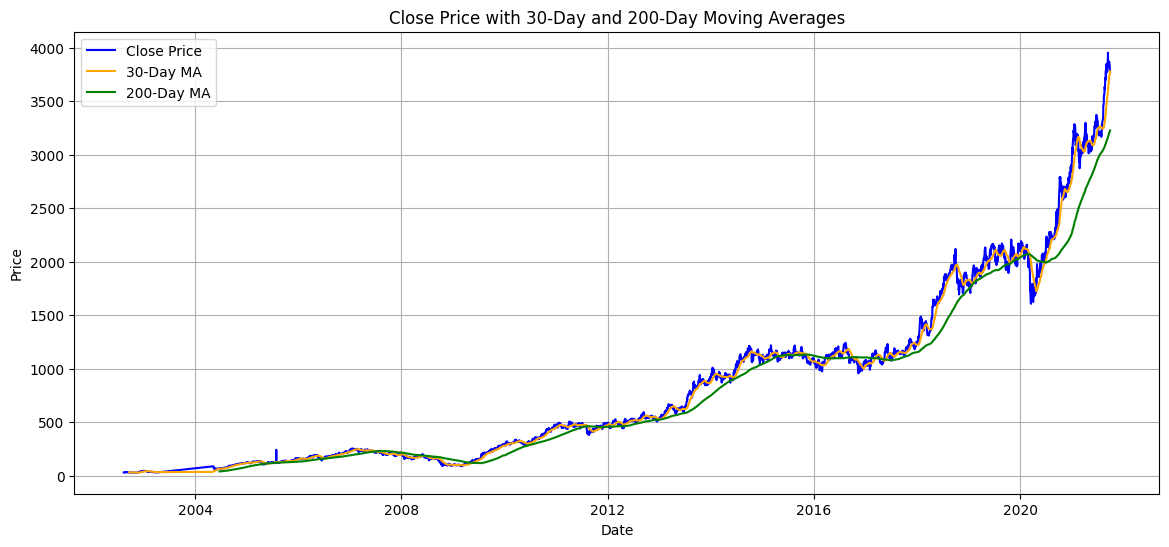

In [14]:
#Moving Averages (30-day & 200-day)
df['MA30'] = df['Close'].rolling(window=30).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['MA30'], label='30-Day MA', color='orange')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price with 30-Day and 200-Day Moving Averages')
plt.legend()
plt.grid(True)
plt.show()


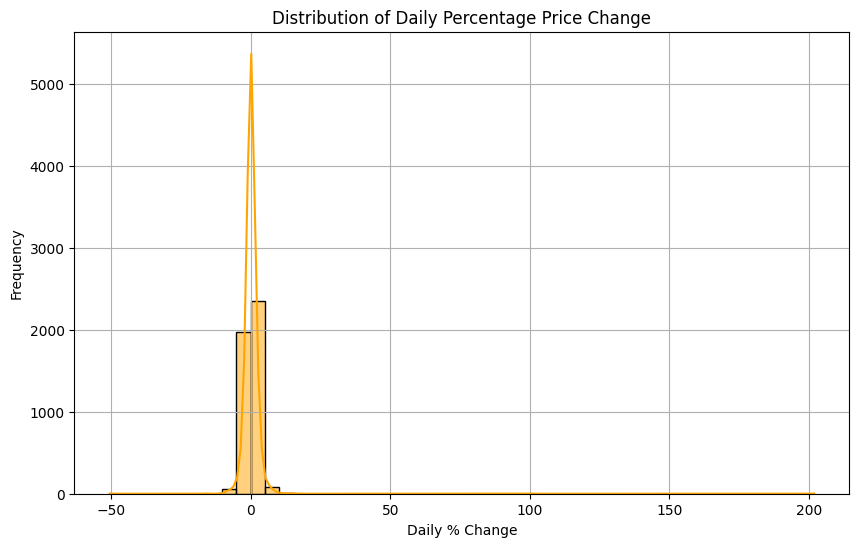

In [15]:
#Daily % Price Change Distribution
df['Daily_Change_%'] = df['Close'].pct_change() * 100

plt.figure(figsize=(10, 6))
sns.histplot(df['Daily_Change_%'].dropna(), bins=50, kde=True, color='orange')
plt.xlabel('Daily % Change')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Percentage Price Change')
plt.grid(True)
plt.show()


In [16]:
#Extract Date-Based Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek


In [17]:
#Create Lag Features
# Previous day’s closing price
df['Prev_Close'] = df['Close'].shift(1)

# Previous day’s volume
df['Prev_Volume'] = df['Volume'].shift(1)


In [18]:
#Rolling Window Features
# 7-day moving average of Close
df['MA_7'] = df['Close'].rolling(window=7).mean()

# 14-day volatility
df['Volatility_14'] = df['Close'].rolling(window=14).std()


In [19]:
#Moving Average Crossover Signal
# Short-term and long-term MAs
df['Short_MA'] = df['Close'].rolling(window=5).mean()
df['Long_MA'] = df['Close'].rolling(window=30).mean()

# Signal: 1 for buy, -1 for sell
df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, -1)


In [20]:
#Drop NA Rows from Feature Creation
df.dropna(inplace=True)

In [21]:
# Defining features
features = [
    'Open', 'High', 'Low', 'Volume',
    'Prev_Close', 'Day_of_Week', 'Month',
    'MA_7', 'Volatility_14', 'Signal'
]

X = df[features]
y = df['Close']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [24]:
y_pred = lr_model.predict(X_test)


In [25]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression Model Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


Linear Regression Model Performance:
Mean Squared Error: 41.54
Mean Absolute Error: 3.97
R² Score: 0.9999


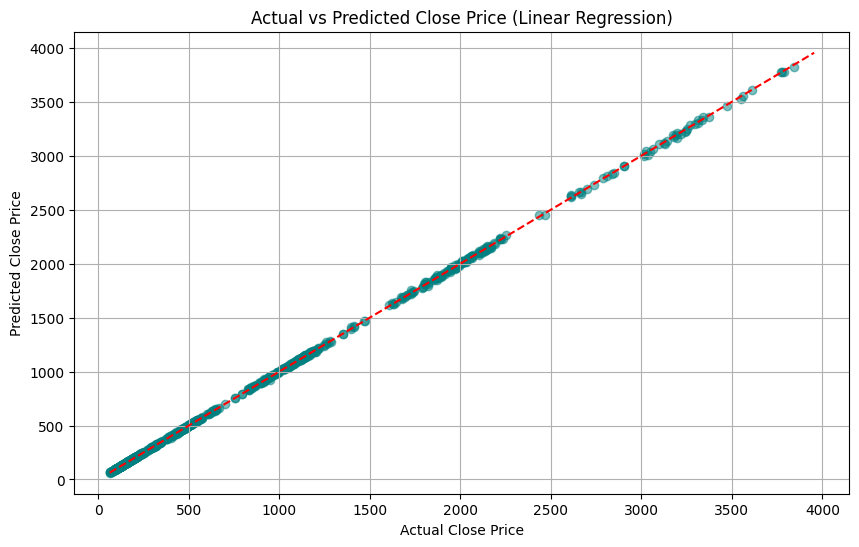

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price (Linear Regression)')
plt.grid(True)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Reference line
plt.show()


In [27]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Use only the Close price for LSTM
close_data = df[['Close']].values

# Normalize data between 0 and 1
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_data)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)



In [28]:
X_lstm, y_lstm = [], []

for i in range(1, len(close_scaled)):
    X_lstm.append(close_scaled[i - 1:i, 0])  # previous value
    y_lstm.append(close_scaled[i, 0])        # current value

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Reshape input to 3D: (samples, timesteps, features)
X_lstm = X_lstm.reshape((X_lstm.shape[0], 1, 1))


In [29]:
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]


In [30]:
BATCH_SIZE = 15
BUFFER_SIZE = 1024

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_lstm, y_train_lstm))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_lstm, y_test_lstm))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


In [32]:
# Train model with GPU + prefetch pipeline
lstm_model.fit(train_dataset, epochs=30, validation_data=test_dataset, verbose=1)


Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.9610e-04 - val_loss: 8.3133e-04
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1138e-06 - val_loss: 7.8980e-04
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8268e-06 - val_loss: 6.7116e-04
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1944e-06 - val_loss: 5.7279e-04
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6032e-06 - val_loss: 5.1056e-04
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9870e-06 - val_loss: 4.1397e-04
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 4.8162e-06 - val_loss: 2.9412e-04
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 6.0779e-06 - val_loss: 3.8904e-04
Epoch 9/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 5.4758e-06 - val_loss: 4.0833e-04
Epoch 10/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8081e-06 - val_loss: 3.3463e-04
Epoch 11/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

In [33]:
# Predict on test set
lstm_pred_scaled = lstm_model.predict(X_test_lstm)

# Inverse scaling
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluation
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
print(f"LSTM Mean Absolute Error: {lstm_mae:.2f}")


LSTM Mean Absolute Error: 35.94


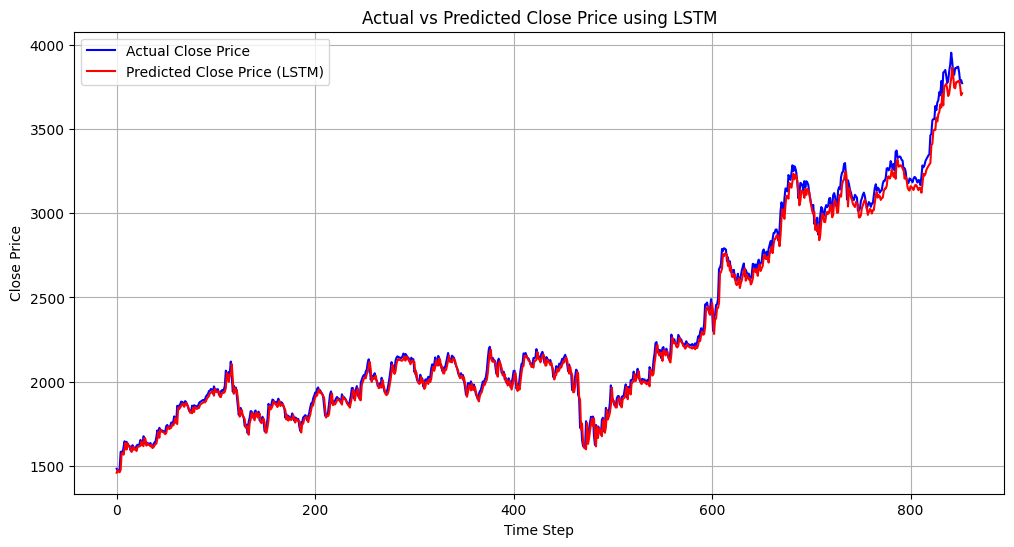

In [36]:
# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Close Price', color='blue')
plt.plot(lstm_pred, label='Predicted Close Price (LSTM)', color='red')
plt.title('Actual vs Predicted Close Price using LSTM')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
import pickle

# Save Linear Regression model
with open('TCS_LR_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save LSTM model (HDF5 format)
lstm_model.save('TCS_LSTM_model.h5')


In [38]:
# Add predictions and actuals to DataFrame
results_df = pd.DataFrame({
    'Actual_Close': y_test_actual.flatten(),
    'Predicted_Close': lstm_pred.flatten()
})

results_df.to_csv('lstm_predictions.csv', index=False)
print("Predictions saved to lstm_predictions.csv")


Predictions saved to lstm_predictions.csv
